# Introduction

Hello my Name is Nurfaldi, I'm a data scientist and Today I want to show you one way of doing image classification project by using Tensorflow. 

Image classification is one of the tasks that can be very useful in many settings. Ever since we can process images on the computer, numerous brilliant scientists and engineers are already trying to classify images using multiple techniques. In the last decade, with the increasing computing power that follows the exponential growth of Moore's law, Neural Network Deep Learning becomes a very viable model, not only for large institutions with supercomputers but for everyone.

Today I want to show you how to make a simple deep learning model using the TensorFlow CNN model and utilize the power of Convoluted layers to train the computer using thousand of images with the final goal of predicting photographs of animals that we would feed into the computer. In the past, this is a tremendous task that can only be accomplished by using the most powerful supercomputers in the world. Today we can do it by ourselves! let's dive in! 

# Import Libraries

First, we need to import the libraries that we would need to use. Most several of the libraries are for loading data (os, shutil, glob, pathlib). pillow (PIL) and Open CV (cv2) will help us explore our data. NumPy and pandas are necessary for data processing. We will use TensorFlow as the deep learning heavy lifter, and we will also use sklearn to evaluate our model

In [5]:
# Import Library

## General Purpose & Data Handling
import os, shutil, glob, pathlib, requests
from datetime import datetime
from pickle import dump 

import PIL, cv2
from io import BytesIO

import numpy as np
import pandas as pd

## Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

## Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix

# Visualization
import matplotlib.pyplot as plt

# Warning Supression if necesseray
# import warnings
# warnings.filterwarnings('ignore')

In [6]:
# GPU Check
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
    
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# Tensorflow Version Check
print(tf.__version__)

Default GPU Device:/device:GPU:0
Mon Jun 27 08:11:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |    375MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                       

In [7]:
# Creating folders in directory for model saving 

dirNames = [r'files/', r'models/']

def create_directory(dirNames):
  for dirs in dirNames:
      try:
          # Create target Directory
          os.mkdir(dirs)
          print("Directory " , dirs ,  " Created ") 
      except FileExistsError:
          print("Directory " , dirs ,  " already exists")

create_directory(dirNames)          

Directory  files/  already exists
Directory  models/  already exists


# Data Loading

Basically, we install Kaggle and load our account info in json file (which we download from Kaggle) and then we can access the data and unzip it if necessary.
We can choose between two methods here, the first one is by storing our kaggle.json in our directory and run the code. the second one which I prefer more is by uploading the kaggle.json file to google drive and connect Colab to google drive for automatic reading. I use this one because I store the output of my code in google drive and I need to login anyway at some point.

In [ ]:
# Import Data for Google Collab with kaggle.json on directory

# ! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download alessiocorrado99/animals10
# ! unzip animals10.zip

# Import Data for Google Collab with kaggle.json in Google Drive

from google.colab import drive
drive.mount('/content/drive')

! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! kaggle datasets download alessiocorrado99/animals10
! unzip animals10.zip

In [9]:
# Data Checking and Count

## Colab/Local
data_path = r'raw-img/'
data_dir = pathlib.Path(r'raw-img/')

## Kaggle
# data_path = r'../input/animals10/raw-img'
# data_dir = pathlib.Path(r'../input/animals10/raw-img')

## Check
image_count = [len(list(data_dir.glob('*/*.jpg'))), len(list(data_dir.glob('*/*.jpeg'))), len(list(data_dir.glob('*/*.png')))]
print('total images :', sum(image_count))

total images : 26179


We can see that we succesfully load the data into our directory, Now lets explore the data.

# Exploratory Data Analysis 

## Paths and Foldername

First thing first let's check the paths in our data folder. We can see it in the file explorer but let's list the paths here

In [10]:
# Checking paths
os.listdir(data_path)

['ragno',
 'pecora',
 'farfalla',
 'gatto',
 'cavallo',
 'elefante',
 'cane',
 'mucca',
 'gallina',
 'scoiattolo']

We can see that our data is divided by animal class, but what animal is 'ragno'?

Hmm after a quick google search and by reading the Kaggle data information, it seems that the directory name is in Italian. Luckily the data comes with a dictionary (translate.py). I'll just get the keys and values and put them here in case we'll need them later.

In [11]:
# Stroring Dictionary of path names {English : Italian}
classes_dictionary_eng_ita = {
'dog'         : 'cane',
'horse'       : 'cavallo',
'elephant'    : 'elefante',
'butterfly'   : 'farfalla',
'chicken'     : 'gallina',
'cat'         : 'gatto',
'cow'         : 'mucca',
'sheep'       : 'pecora',
'spider'      : 'ragno',
'squirrel'    : 'scoiattolo',
}

# And for the {Italian : English}
classes_dictionary_ita_eng = {v: k for k, v in classes_dictionary_eng_ita.items()}

## Distribution

Let's explore our data, first let's see the distribution by file types

In [12]:
# Printing distribution
print('jpg images   :', image_count[0])
print('jpeg images  :', image_count[1])
print('png images   :', image_count[2])
print('total images :', sum(image_count))

jpg images   : 1919
jpeg images  : 24209
png images   : 51
total images : 26179


It seems that our data is dominated by 24.209 jpeg images which made up more than 90% of our data. We also have 1.919 jpg data type which is practically a same datatype as jpeg, and last we have 51 png images which is fundamentally a different photo format from jpg/jpeg.

Now what about the number of image in each folder? to answer this, I will orginze our data into Pandas DataFrame by label and directory.

In [13]:
# Assigining directroy to animal names
dog         = pd.Series(data_dir.glob('cane' + '/*'))
horse       = pd.Series(data_dir.glob('cavallo' + '/*'))
elephant    = pd.Series(data_dir.glob('elefante' + '/*'))
butterfly   = pd.Series(data_dir.glob('farfalla' + '/*'))
chicken     = pd.Series(data_dir.glob('gallina' + '/*'))
cat         = pd.Series(data_dir.glob('gatto' + '/*'))
cow         = pd.Series(data_dir.glob('mucca' + '/*'))
sheep       = pd.Series(data_dir.glob('pecora' + '/*'))
spider      = pd.Series(data_dir.glob('ragno' + '/*'))
squirrel    = pd.Series(data_dir.glob('scoiattolo' + '/*'))

# Creating dataframe
df = pd.DataFrame([dog, horse, elephant, butterfly, chicken, cat, cow, sheep, spider, squirrel]).T
df.columns = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']
df = df.melt().dropna().reset_index(drop=True)
df.columns = ['label', 'directory']
df.sample(5)

,label,directory
25198,squirrel,raw-img/scoiattolo/OIP-TYYgz-eedmD-eFV_D-8sOAH...
13912,chicken,raw-img/gallina/OIP-aL0nASaiCjdaqiyix1S6YgHaE8...
10995,butterfly,raw-img/farfalla/OIP-9kXGvV_wMBEtLca7Bp-8vQHaJ...
3204,dog,raw-img/cane/OIP-9j0jBz5wwwsg2fH_gRf_swHaFf.jpeg
2798,dog,raw-img/cane/OIP-h8t_ncuzpun7rxufMqDhHAHaE8.jpeg


From the sample of the data frame we can see the label on the left side and directory on the right side, now lets plot the number of files in each label.

           directory
label               
dog             4863
spider          4821
chicken         3098
horse           2623
butterfly       2112
cow             1866
squirrel        1862
sheep           1820
cat             1668
elephant        1446 



<BarContainer object of 10 artists>

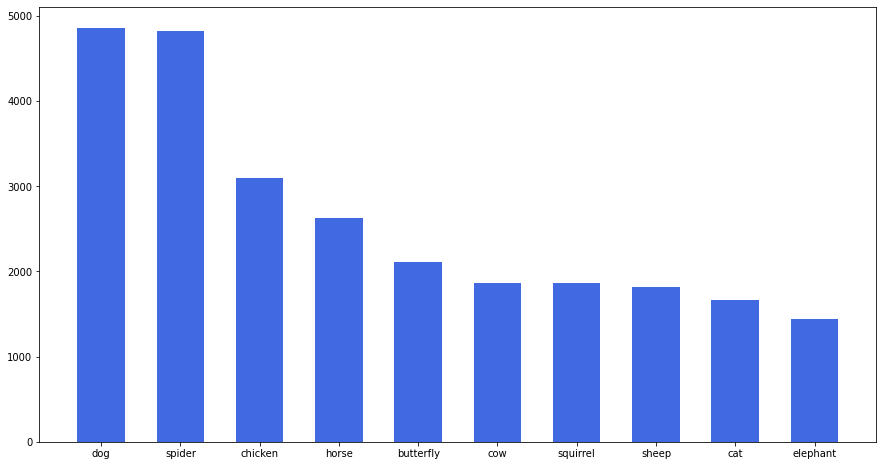

In [14]:
# Plotting number of picture by label
df_plot = df.groupby('label').count().sort_values(by='directory', ascending=False)

print(df_plot, '\n')

plt.figure(figsize=(15, 8))
plt.bar(df_plot.index, df_plot['directory'], color ='royalblue',
        width = 0.6)

We can see here that dogs, and spiders are dominating the picture distribution with around 4800 entries each. the other class count is varied but the variation is relatively low at around 1500 to 3000 images per class. Elephants have the lowest count at 1446.

## Images and their sizes

Since we're processing pictures it is not fun to just talk about numbers. Let's see the images!

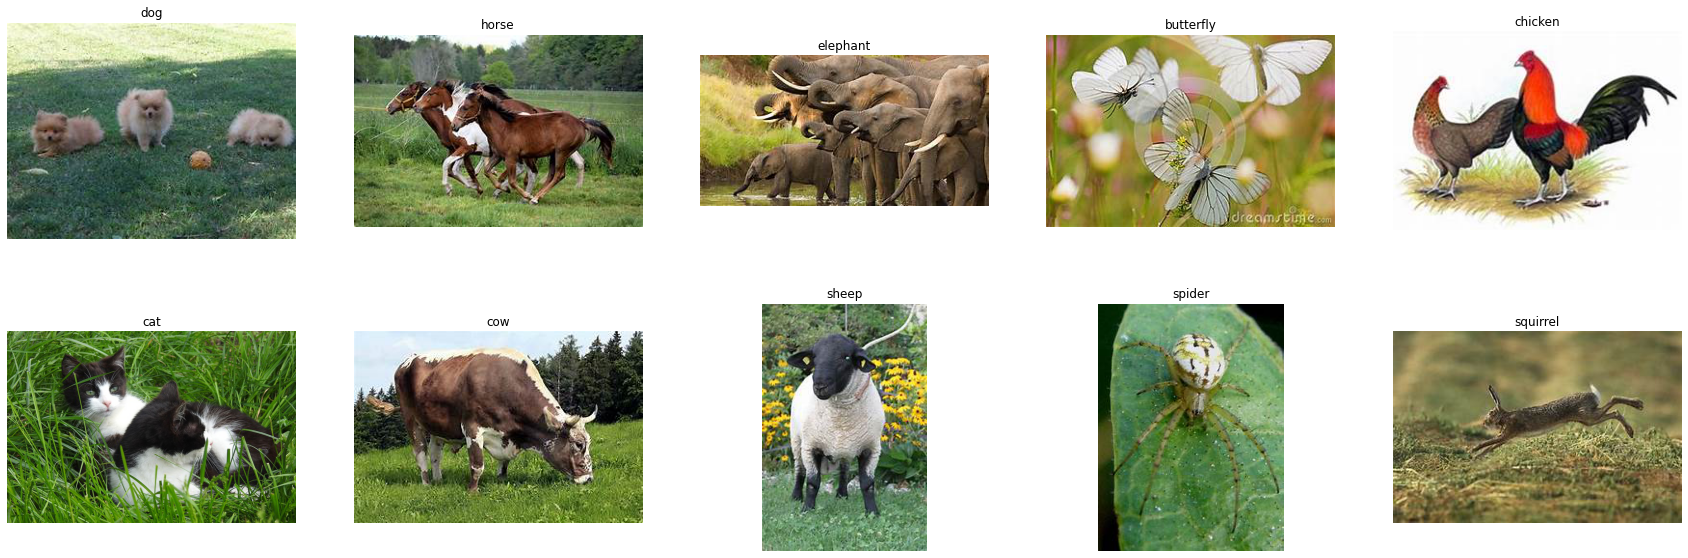

In [15]:
# Plotting random images from each category
col_names = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']
counter = 1

plt.figure(figsize=(30, 10))
for animal in col_names:
  dir = df[df['label'] == animal]['directory'].sample(1)
  ax = plt.subplot(2, 5, counter)
  plt.imshow(PIL.Image.open(str(dir.iloc[0])))
  plt.title(df['label'][dir.index].iloc[0])
  plt.axis("off")

  counter += 1

We can see that our data contains multiple images of lovely animals in different picture sizes. We would need to handle this later because Deep Learning models cannot take data with different-sized inputs.

Now I want to make a gif sampled from our data.

In [16]:
[PIL.Image.open(str(df['directory'][np.random.randint(26000)])) for x in np.arange(10)]

def make_square(im, min_size=256, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = PIL.Image.new('RGBA', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

images = [make_square(PIL.Image.open(str(df['directory'][np.random.randint(26000)]))) for x in np.arange(100)]

# Save the frames as an animated GIF
images[0].save('/content/drive/MyDrive/pictures/animals.gif',
               save_all=True,
               append_images=images[1:],
               duration=300,
               loop=0)

images[0].save('animals.gif',
               save_all=True,
               append_images=images[1:],
               duration=300,
               loop=0)

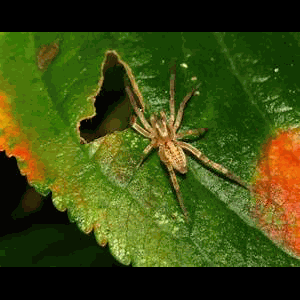

In [17]:
PIL.Image.open('/content/animals.gif')

Sadly, it seems that the gif is not running in Google Colab :( 

If you want to see it I uploaded the file here: 

[Click Here for Animals!](https://drive.google.com/file/d/1--SiWW2bTammPXabq_zB4ZKXljONcAE7/view?usp=sharing)

Now we would want to look into the sizes of our images. we will make an image size DataFrame and plot the image size distribution.

In [18]:
dfx = df.copy()

heights = []
widths = []

for i in np.arange(len(dfx)):
  h, w = PIL.Image.open(str(dfx['directory'][i])).size
  heights.append(h)
  widths.append(w) 

dfx['height'] = heights
dfx['width'] = widths

dfx.sample(5)

,label,directory,height,width
19610,spider,raw-img/ragno/OIP-6HD_pA1vevX9YzwNVpU8mgHaFH.jpeg,300,207
20760,spider,raw-img/ragno/OIP-vCtBXe_oEsx9iS0c-NETEAHaJ5.jpeg,225,300
7202,horse,raw-img/cavallo/OIP-v8rK-S1Dyn7gKqnay546lAHaJ8...,224,300
274,dog,raw-img/cane/OIP-aMbTBEXXfKY3y4-xyT8mwQHaEd.jpeg,300,181
24384,squirrel,raw-img/scoiattolo/OIP-00qwuq8LDwY8bqltA0QfzwH...,201,300


In [19]:
dfx.describe()

,height,width
count,26179.000000,26179.000000
mean,320.038810,252.630162
std,196.935326,148.403298
min,60.000000,57.000000
25%,300.000000,200.000000
50%,300.000000,225.000000
75%,300.000000,300.000000
max,6720.000000,6000.000000


We can see here that most of our data have a height of 300 pixels. the width though, varied with 200-300 pixels as the majority. It seems that some pictures have a high resolution at around 6000 pixels size. We would need to adjust our distribution plot accordingly

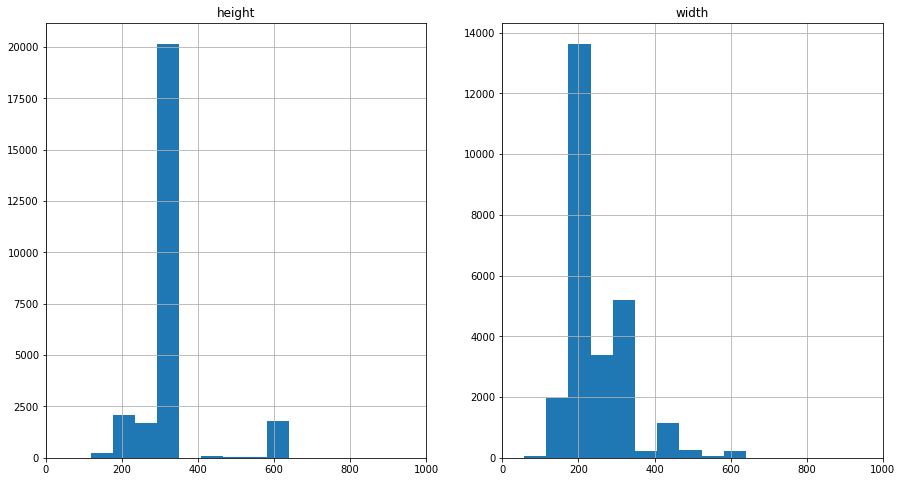

In [20]:
# Plotting Distribution of height and weigth for value < 1000
plt.figure(figsize=(15,8))

ax = plt.subplot(1, 2, 1)
dfx[dfx['height'] < 1000]['height'].hist()
plt.xlim([0, 1000])
plt.title('height')

ax = plt.subplot(1, 2, 2)
dfx[dfx['width'] < 1000]['width'].hist()
plt.xlim([0, 1000])
plt.title('width')

plt.show()

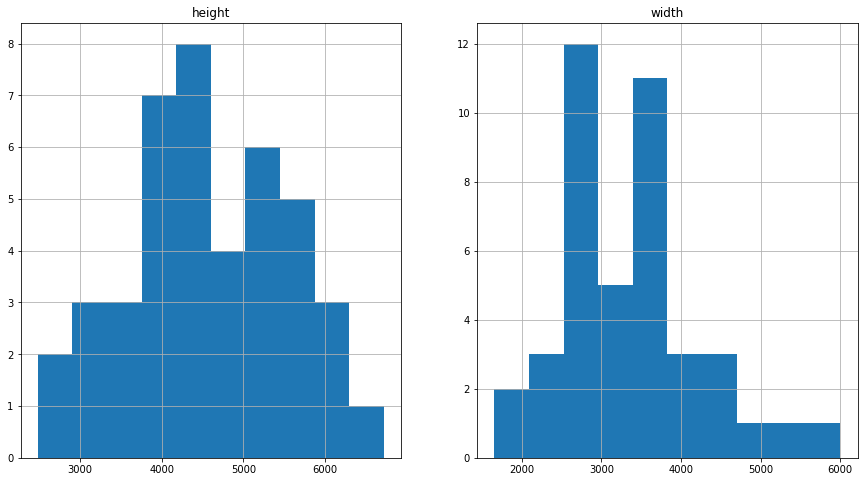

In [21]:
# Plotting Distribution of height and weigth for value < 1000

plt.figure(figsize=(15,8))

ax = plt.subplot(1, 2, 1)
dfx[dfx['height'] > 1000]['height'].hist()
plt.title('height')

ax = plt.subplot(1, 2, 2)
dfx[dfx['width'] > 1000]['width'].hist()
plt.title('width')

plt.show()

These small numbers of pictures with bigger sizes would not be a problem since we will rescale all the pictures into smaller dimensions later.

Yeeay we're done exploring our data, after this we will dive into Deep learning modeling

# Data Preprocessing

## Split Train Validation, Set Image Size and Batch Size

In this step, we're splitting train and test datasets using tf.keras.utils.image_dataset_from_directory() function. You can read more about this in the documentation and here: https://www.tensorflow.org/tutorials/load_data/images for more updated approach of local data loading in TensorFlow

In [22]:
# Set variables
img_width=256
img_height=256
batch_size=32

In [24]:
# Train Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  color_mode='rgb',
  validation_split=0.2,
  subset="training",
  seed=165,
  image_size=(img_height, img_width),
  crop_to_aspect_ratio=False,
  batch_size=batch_size)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.


In [25]:
# Assigning Class Name to English Class Name
class_names = train_ds.class_names
class_names_eng = []
for i in class_names:
  class_names_eng.append(classes_dictionary_ita_eng[i])

print([class_names_eng])
print([class_names])

[['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']]
[['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']]


In [47]:
# Val Dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  color_mode='rgb',    
  validation_split=0.2,
  subset="validation",
  seed=165,
  image_size=(img_height, img_width),
  crop_to_aspect_ratio=False,
  batch_size=batch_size)

Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


In [50]:
val_ds.class

SyntaxError: ignored

A few notes about using .image_dataset_from_directory() is that you will do some of the preprocessing processes here. for example:

1. we set the color map as 'rgb' since we are using colored pictures and the animal colors is useful information in identifying animals since different animals have different colors
2. We also set our image size here. Image size should be optimized to the computing power one had in their hand. higher resolution images could result in a more accurate model but need substantially more computing power
3. Similar to image size, we also determine batch size with computer optimization in mind. A larger batch size means the model will train our data faster and with fewer steps per epoch but for image processing, a larger batch size will increase memory usage significantly, so we need to optimize this carefully to prevent OOM (out of memory) error.

We can also choose to set crop_to_aspect_ratio to true to maintain the aspect ratio after preprocessing, but we'll need to handle this later to maintain input shape.


In [27]:
# dataset_count = 22253
# train_val_ds = train_val_ds
# train_ds = train_val_ds.take(int(dataset_count*0.8))
# val_ds = train_val_ds.skip(int(dataset_count*0.8))

## Data Optimization

In [28]:
# Optimizing Data using prefetch

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)


Here we optimize the data using the Tensorflow pipeline to make training faster. Cache is used to store data after training so the same data would not be loaded multiple times. prefetch is used to get data from disk before the data is requested so the model can fetch the data using CPU while training using GPU.

# Model Definition

Now we can make our initial model. I'm using an example from https://www.tensorflow.org/tutorials/images/classification as our initial model architecture. The model is a sequencial model with an input layer that takes image width, height, and channel as input. then we use the rescaling layer to scale the pixel from 0-255 to 0-1. after that we use a combination of 3 pairs of convolutional2D and MaxPooling2D layers with an increasing number of nodes in each layer. this approach is taken from many examples in convolutional deep learning models. At the end, of our model, we use Flatten and two dense layers to scale down the output of convolutional layers before we classify our model into 10 label class 

In [29]:
num_classes = 10

model_base = Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    # Rescale to 1-255
    layers.experimental.preprocessing.Rescaling(1./255),

    # Covulutional Layers
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Flaten and a dense layer before classification
    layers.Flatten(),
    layers.Dense(128, activation='relu'),

    # Flaten and the Last Dense layer for classification result
    layers.Dense(num_classes)
])

In [30]:
model_base.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

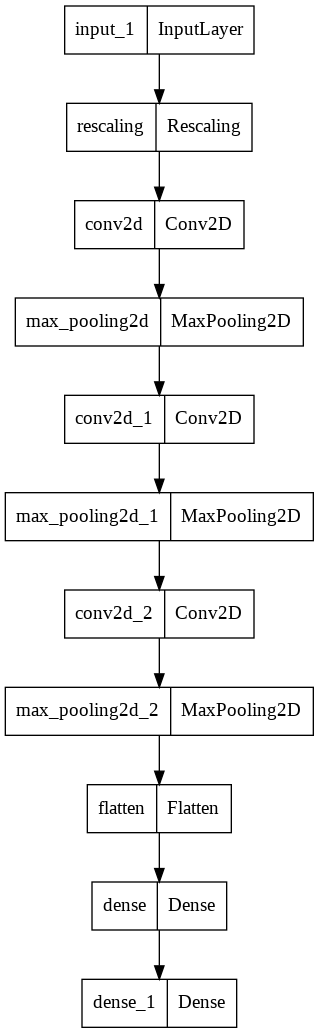

In [31]:
plot_model(model_base, "model_initial.png")

This plot shows a clearer picture of our model

# Model Training

We trying to run 50 epochs as our first run with 'loss' as an early stopping callback. This is to monitor how much our model can improve for the training data set and also to see if overfitting occurs later

In [36]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', baseline=None, patience=5)
checkpoint_cb = keras.callbacks.ModelCheckpoint("checkpoint_model.h5", monitor = 'val_accuracy',initial_value_threshold = 0.70, save_best_only=True)
epochs=50

In [ ]:
history = model_base.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[
               callback, 
               checkpoint_cb,
              ]
)

model_base.save(r'models/base_model/base_model.h5')
model_base.save_weights(r'models/base_model//base_weights.ckpt')

Epoch 1/50
655/655 [==============================] - 81s 75ms/step - loss: 1.7758 - accuracy: 0.3987 - val_loss: 1.4792 - val_accuracy: 0.5001
Epoch 2/50
655/655 [==============================] - 58s 68ms/step - loss: 1.2335 - accuracy: 0.5826 - val_loss: 1.2351 - val_accuracy: 0.5786
Epoch 3/50
655/655 [==============================] - 59s 67ms/step - loss: 0.8807 - accuracy: 0.7047 - val_loss: 1.2047 - val_accuracy: 0.6201
Epoch 4/50
655/655 [==============================] - 62s 70ms/step - loss: 0.5373 - accuracy: 0.8242 - val_loss: 1.3493 - val_accuracy: 0.6120
Epoch 5/50
655/655 [==============================] - 55s 63ms/step - loss: 0.2616 - accuracy: 0.9167 - val_loss: 1.6641 - val_accuracy: 0.6136
Epoch 6/50
655/655 [==============================] - 54s 63ms/step - loss: 0.1293 - accuracy: 0.9590 - val_loss: 2.1374 - val_accuracy: 0.6038
Epoch 7/50
655/655 [==============================] - 54s 63ms/step - loss: 0.0808 - accuracy: 0.9754 - val_loss: 2.5207 - val_accuracy:

# Model Evaluation

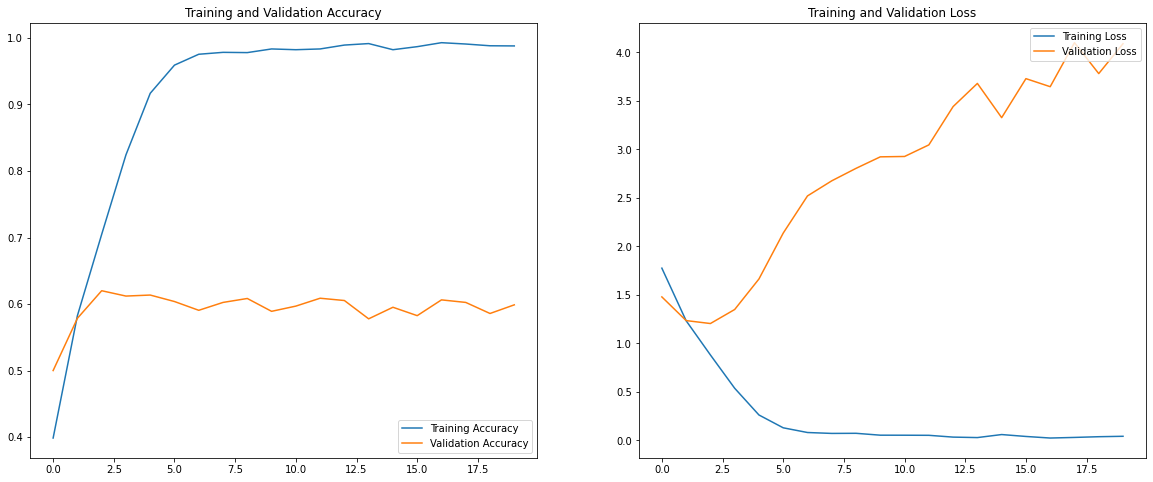

In [40]:
# Plot result
epochs_range = range(20)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can see from the graph, we reach our peak validation accuracy at around 0.6 whilst our train accuracy keeps climbing to 0.988 at epoch 20. the stark difference between the two values is a sign of overfitting. 

For loss, we can see that training loss is decreasing steadily from about 1.77 to 0.04 at epoch 20 where it stops improving (since we use loss as callback stopping criteria). the validation loss on the other hand is decreasing until the third epoch where it changes its direction and climbs to 4.09 at epoch 20. This is a sign of overfitting which is caused by overtraining.

From here we can try to improve our model by modifying its parameters. Another thing to consider is to use a pre-trained cutting-edge algorithm to boost our model. 

## Model Improvement

Now we will try to improve our model by image augmentation. Image augmentation is a technique that manipulates images and generates new images from initial images by applying techniques such as flip, rotation, and zoom. Now we will apply those three kinds of augmentation to our model to improve its training data.  

In [42]:
# setting Augmentattion
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

After we add augmentation layers we will also apply dropout to reduce the number of our neurons after each training. this is done to reduce overfitting. in CNN the paramter of dropout can be quite large and we'll use 0.3 for this model

In [43]:
# Improved Model

num_classes = 10

model_improved = Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),

    data_augmentation,
    # Rescale to 1-255
    layers.experimental.preprocessing.Rescaling(1./255),

    # Covulutional Layers
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Adding Dropout
    layers.Dropout(0.2),

    # Flaten and a dense layer before classification
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    

    # Flaten and the Last Dense layer for classification result
    layers.Dense(num_classes)
])

model_improved.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_improved.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

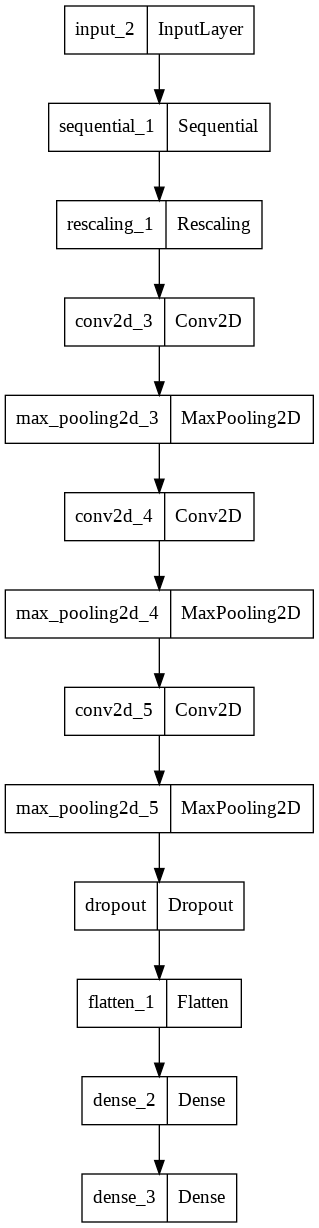

In [44]:
plot_model(model_improved, "model_improved.png")

Again We will run 50 epochs  with 'loss' as an early stopping callback  to monitor how much our model can improve for the training data set and also to see any overfitting pattern

In [ ]:
# Training

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', baseline=None, patience=3)
checkpoint_cb = keras.callbacks.ModelCheckpoint(r'models/checkpoint_model/checkpoint_model.h5', monitor = 'val_accuracy',initial_value_threshold = 0.65, save_best_only=True)
epochs=50

improved_history = model_improved.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[
               callback, 
               checkpoint_cb
              ]
)

model_improved.save(r'models/improved_model/improved_model.h5')
model_improved.save_weights(r'models/improved_model//improved_weights.ckpt')

with open('/content/files/improvedHistoryDict', 'wb') as file_pi:
    dump(improved_history.history, file_pi)

Epoch 1/50
655/655 [==============================] - 58s 88ms/step - loss: 0.8120 - accuracy: 0.7267 - val_loss: 1.0784 - val_accuracy: 0.6520
Epoch 2/50
655/655 [==============================] - 53s 80ms/step - loss: 0.7868 - accuracy: 0.7333 - val_loss: 1.0600 - val_accuracy: 0.6619
Epoch 3/50
655/655 [==============================] - 52s 79ms/step - loss: 0.7728 - accuracy: 0.7366 - val_loss: 1.1273 - val_accuracy: 0.6491
Epoch 4/50
655/655 [==============================] - 54s 82ms/step - loss: 0.7573 - accuracy: 0.7442 - val_loss: 1.0262 - val_accuracy: 0.6642
Epoch 5/50
655/655 [==============================] - 53s 80ms/step - loss: 0.7329 - accuracy: 0.7467 - val_loss: 1.0416 - val_accuracy: 0.6695
Epoch 6/50
655/655 [==============================] - 52s 79ms/step - loss: 0.7221 - accuracy: 0.7537 - val_loss: 1.1193 - val_accuracy: 0.6571
Epoch 7/50
655/655 [==============================] - 54s 82ms/step - loss: 0.7094 - accuracy: 0.7595 - val_loss: 1.0427 - val_accuracy:

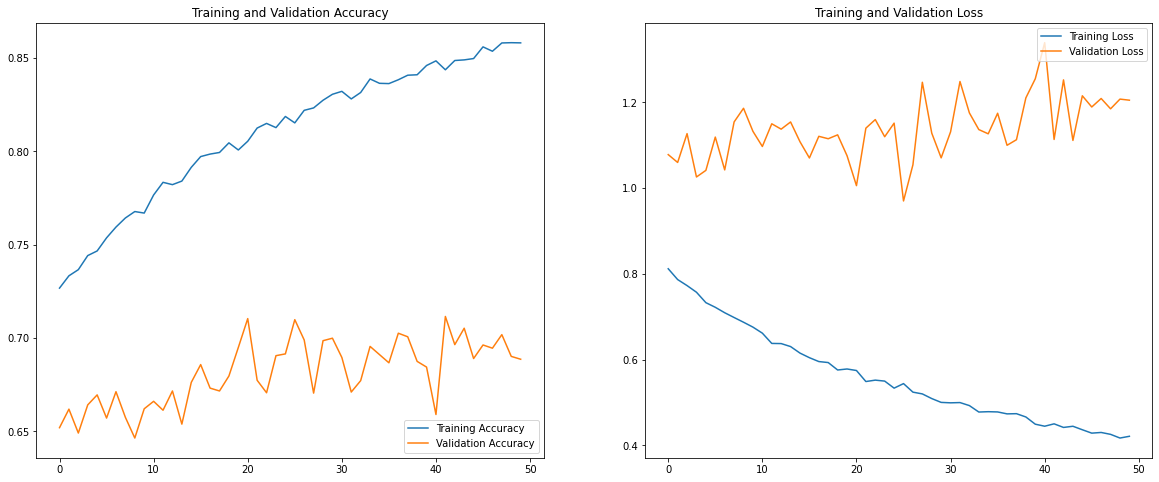

In [ ]:
#plotting result

acc = improved_history.history['accuracy']
val_acc = improved_history.history['val_accuracy']

loss = improved_history.history['loss']
val_loss = improved_history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Interestingly our model has indeed improved its accuracy to around 70% after training but if we look at the loss, we can see that the validation loss is fluctuating from around 1 to 1.3 and even generally increases. this is still a sign of overfitting and we would need to try more things in the future to handle this. 

# Model Saving

From our two model the improved one is better than the base one so we will export this as our best model.

In [51]:
# Export Model
model_improved.save(r'models/best_model/best_model.h5')
model_improved.save_weights(r'models/best_model//best_model.ckpt')

# Model Inference

In [52]:
model_loaded = keras.models.load_model(r'models/best_model/best_model.h5')
#model.load_weights("best_model_weights.ckpt")

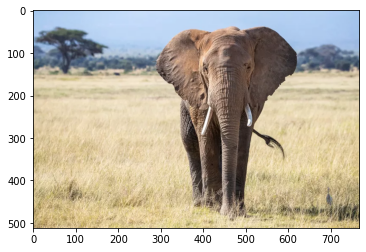

In [53]:
url = 'https://www.treehugger.com/thmb/6yokxKPkefQr6bjJ2P2ZKg0eTXQ=/768x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/front-view-of-a-bull-elephant-in-the-grasslands-of-amboseli-national-park--1219745751-08f3add138514ad091e82e29a11546cc.jpg'
response = requests.get(url)
img = PIL.Image.open(BytesIO(response.content))
plt.imshow(img)

In [56]:
def predict_picture(img, model, class_names=class_names_eng):
    img_rs = img.resize((256, 256))

    img_array = keras.preprocessing.image.img_to_array(img_rs)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names_eng[np.argmax(score)], 100 * np.max(score))
    )

    plt.imshow(img)
    plt.show()

    return predictions

This image most likely belongs to elephant with a 88.55 percent confidence.


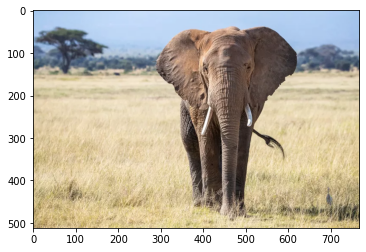

array([[  3.6930768,   6.4955306,   9.110607 ,  -2.3627524,   2.5686142,
         -6.755826 ,   5.927177 ,   4.380474 , -11.713843 ,  -7.2457767]],
      dtype=float32)

In [58]:
predict_picture(img, improved_model, class_names=class_names_eng)

# Conclusion

Making an image classification using a deep learning model is not a simple task yet very doable and we can learn to do it on our own using resources that are available and developed by brilliant developers and engineers online.

Our model from this trial is not the best model but as we try before, we can improve its performance by using augmentation and adding adjustment layers. later we can try to do more fine-tuning to get a better result from our model.

# Debugging and Others

In [ ]:
stop run here

In [ ]:
base_model = keras.models.load_model("/content/models/base_model/base_model.h5")
checkpoint_model = keras.models.load_model("/content/models/checkpoint_model/checkpoint_model.h5")
gacha_model = keras.models.load_model("/content/models/gacha_model/gacha_model.h5")
improved_model = keras.models.load_model("/content/models/improved_model/improved_model.h5")

In [ ]:
model_improved.save(r'models/improved_model/improved_model.h5')
model_improved.save_weights(r'models/improved_model//improved_weights.ckpt')

In [ ]:
%cp -av "/content/models" "/content/drive/MyDrive/models_exported/models"

In [41]:
%cp -av "/content/drive/MyDrive/models_exported/models" "/content"

'/content/drive/MyDrive/models_exported/models' -> '/content/models/models'
'/content/drive/MyDrive/models_exported/models/base_model' -> '/content/models/models/base_model'
'/content/drive/MyDrive/models_exported/models/base_model/base_weights.ckpt.data-00000-of-00001' -> '/content/models/models/base_model/base_weights.ckpt.data-00000-of-00001'
'/content/drive/MyDrive/models_exported/models/base_model/checkpoint' -> '/content/models/models/base_model/checkpoint'
'/content/drive/MyDrive/models_exported/models/base_model/base_weights.ckpt.index' -> '/content/models/models/base_model/base_weights.ckpt.index'
'/content/drive/MyDrive/models_exported/models/base_model/base_model.h5' -> '/content/models/models/base_model/base_model.h5'
'/content/drive/MyDrive/models_exported/models/.ipynb_checkpoints' -> '/content/models/models/.ipynb_checkpoints'
'/content/drive/MyDrive/models_exported/models/gacha_model' -> '/content/models/models/gacha_model'
'/content/drive/MyDrive/models_exported/models

In [ ]:
%cp -av "/content/files" "/content/drive/MyDrive/models_exported/files"

'/content/files' -> '/content/drive/MyDrive/models_exported/files'
'/content/files/save_history_plot__2022_06_26-02:40:37_PM.txt' -> '/content/drive/MyDrive/models_exported/files/save_history_plot__2022_06_26-02:40:37_PM.txt'
'/content/files/improvedHistoryDict' -> '/content/drive/MyDrive/models_exported/files/improvedHistoryDict'


In [ ]:
date = datetime.now().strftime("%Y_%m_%d-%I:%M:%S_%p")
filename = f"save_history_plot_{date}"

save_history_plot = 'asd'

with open(r'files/' + x +'.txt', "a") as o:
    o.write(str(save_history_plot))

 Conceptual Questions
 
 Dapatkah Student menjelaskan alasan suatu teknik preprocessing dipilih ? (Jangan hanya mengikuti saja dari sumber yang dibaca.)

* Dapatkah Student menjelaskan arsitektur yang dirancang, baik dari segi jumlah layer, jumlah neuron, dll ?

* Apa maksud dari performansi yang didapatkan baik saat training maupun testing ?

* Dapatkah teman-teman menjelaskan data seperti apa yang akan diprediksi salah oleh model ? (Coba jawab pertanyaan ini untuk tugas Milestone 2 ini)

* Jika menggunakan transfer learning, mengapa algoritma tersebut yang dipilih ? Apa keistimewaannya ? Darimana landasannya ?